In [ ]:
run_imp = '''
addi    sp, sp, -2032
sd      ra, 2024(sp)                    # 8-byte Folded
sd      s0, 2016(sp)                    # 8-byte Folded
lui     a1, 32
addiw   a1, a1, -2000
sub     sp, sp, a1
mv      s0, a0
addi    a0, sp, 16
addi    a2, zero, 120
mv      a1, s0
call    memcpy@plt
addi    a0, sp, 16
call    run_imp_actual(long*)
addi    a1, sp, 16
addi    a2, zero, 120
mv      a0, s0
call    memcpy@plt
lui     a0, 32
addiw   a0, a0, -2000
add     sp, sp, a0
ld      s0, 2016(sp)                    # 8-byte Folded Reload
ld      ra, 2024(sp)                    # 8-byte Folded Reload
addi    sp, sp, 2032
ret
'''

def print_riscv_instruction(instruction):
    op,i0,i1 = instruction[:3] #assigns the instruction components
    output = instruction[3].strip('\n\t')
    binaryops = {'Plus':'ADD','Minus':'SUB','Times':'MUL','Greater':'SGT','And':'AND','Or':'OR'}
    jumpops = {'JumpIfZero':'BEQZ','JumpIfNonzero':'BNEZ'}
    
    stack = lambda i : str(8*int(i)) + '(a0)' #converts stack index 
    load_stack = lambda i, a: "LD "+a+", "+ stack(i) + "\n\t"  #load ith value from stack to register a
    save_stack = lambda i, a: "SD "+a+", "+ stack(i) + "\n\t"  #save register a to ith index in stack
    binaryop = lambda out_reg, ai, aj, opname: opname + " " + out_reg + ", " + ai +", " + aj + "\n\t" #perform operation a1 op a2, put result in output register
    unaryop = lambda arg1, arg2, opname: opname + " " + arg1 + ", " + arg2 + '\n\t'
    
    if op in binaryops: 
        riscv = load_stack(i0,'a1') + \
        load_stack(i1,'a2') + \
        binaryop('a1','a1','a2',binaryops[op]) + \
        save_stack(output,'a1')
    
    elif op in jumpops:
        riscv = load_stack(i0,'a1') + \
        unaryop('a1',i1,jumpops[op])
        
    elif op == 'GreaterEq': #a3 = (a1 < a2), then a1 = not a3, save a1 to stack output
        riscv = load_stack(i0,'a1') + \
        load_stack(i1,'a2') + \
        binaryop('a3','a1','a2','SLT') + \
        unaryop('a1','a3','NOT') + \
        save_stack(output,'a1')
        
    elif op == 'Equal': #a3 = (a1 < a2), a4 = (a1 > a2), a2 = (a3 xor a4), a1 = not a2, save a1 to stack output
        riscv = load_stack(i0,'a1') + \
        load_stack(i1,'a2') + \
        binaryop('a3','a1','a2','SLT') + \
        binaryop('a4','a1','a2','SGT') + \
        binaryop('a2','a3','a4','XOR') + \
        unaryop('a1','a2','NOT') + \
        save_stack(output,'a1')
        
    elif op == 'Not': 
        riscv = load_stack(i0,'a1') + \
        unaryop('a1','a1','NOT') + \
        save_stack(output,'a1')
        
    elif op == 'LoadConstant':
        riscv = unaryop('a1',i0,'LI') + \
        save_stack(output,'a1')
        
    elif op == 'Label':
        riscv = i0 + '\n\t'
        
    elif op == 'Move':
        riscv = load_stack(i0,'a1') + \
        save_stack(output,'a1')
        
    elif op == 'Jump':
        riscv = 'JAL x0, ' + i0
        
    else: assert False, 'operation not found'
    
    return riscv

def print_run_imp_actual(instructions):
    run_imp_actual = 'run_imp_actual(long*):\n\t'
    for i in instructions:
        run_imp_actual+=print_riscv_instruction(i)
    return run_imp_actual
    

In [ ]:
with open('../example_op_file.txt', 'r') as f:
    operations = f.readlines()
    instructions = [o.split(' ') for o in operations]

# #Printing each intermediate instruction and its riscv translation
# for i in instructions:
#     op,i0,i1 = i[:3] #assigns the instruction components
#     output = i[3].strip('\n\t')
#     print('instruction: ',op,i0,i1,output)
#     print('\t'+print_riscv_instruction(i))

print(print_run_imp_actual(instructions))
print(run_imp)

In [150]:
def make_cfg(fname,printIns=False):    
    cfg={}
    
    #helper functions
    op=lambda i: i[0]
    i0=lambda i: i[1]
    i1=lambda i: i[2]
    output=lambda i: i[3]
    label=lambda i: i[4].strip('\n')
    jumpto_uncond=lambda i: i0(i).split('_')[-1]
    jumpto_cond=lambda i: i1(i).split('_')[-1]
    def connect(i,x,edge_annotation=''): 
        assert i!=x,'self-connection detected'
        if label(i) not in cfg: cfg[label(i)]=[]
        if x not in [z[0] for z in cfg[label(i)]]:
            cfg[label(i)].append((x,edge_annotation))
    
    #load instructions
    with open(fname, 'r') as f:
        operations = f.readlines()
        instructions = [o.split(' ') for o in operations]
    
    if printIns:
        for i in instructions:print(i[0][:5],'\t\t',i[1][-2:],'\t',i[2][-2:],'\t',i[3],'\t',i[4].strip('\n'))
        
    #main loop
    for ni,i in enumerate(instructions[:-1]):
        next_i=instructions[ni+1]
        if op(i) == 'Jump': connect(i,jumpto_uncond(i),edge_annotation='Jump')
        if op(i) in ('JumpIfNonzero','JumpIfZero'): 
            connect(i,label(next_i),edge_annotation='else')
            connect(i,jumpto_cond(i),edge_annotation=op(i))
        if label(i) != label(next_i):
            connect(i,label(next_i))

    return cfg

cfg_collatz=make_cfg('../programs/collatz.ins',printIns=True)
cfg_arith=make_cfg('../programs/arith.ins')
cfg_factorial=make_cfg('../programs/factorial.ins')
cfg_collatz

Move 		 0 	 ll 	 1 	 1
LoadC 		 0 	 ll 	 6 	 2
Move 		 6 	 ll 	 5 	 2
Label 		 _3 	 ll 	 null 	 3
LoadC 		 1 	 ll 	 8 	 3
Great 		 1 	 8 	 6 	 3
JumpI 		 6 	 13 	 null 	 3
Label 		 _4 	 ll 	 null 	 4
Move 		 1 	 ll 	 4 	 4
LoadC 		 0 	 ll 	 6 	 5
Move 		 6 	 ll 	 3 	 5
Label 		 _6 	 ll 	 null 	 6
LoadC 		 1 	 ll 	 8 	 6
Great 		 4 	 8 	 6 	 6
JumpI 		 6 	 _9 	 null 	 6
Label 		 _7 	 ll 	 null 	 7
LoadC 		 2 	 ll 	 8 	 7
Minus 		 4 	 8 	 6 	 7
Move 		 6 	 ll 	 4 	 7
LoadC 		 1 	 ll 	 8 	 8
Plus 		 3 	 8 	 6 	 8
Move 		 6 	 ll 	 3 	 8
Jump 		 _6 	 ll 	 null 	 8
Label 		 _9 	 ll 	 null 	 9
LoadC 		 0 	 ll 	 8 	 9
Equal 		 4 	 8 	 6 	 9
JumpI 		 6 	 11 	 null 	 9
Move 		 3 	 ll 	 1 	 10
Jump 		 12 	 ll 	 null 	 11
Label 		 11 	 ll 	 null 	 11
LoadC 		 3 	 ll 	 7 	 11
LoadC 		 1 	 ll 	 10 	 11
Plus 		 1 	 10 	 8 	 11
Times 		 7 	 8 	 6 	 11
Move 		 6 	 ll 	 1 	 11
Label 		 12 	 ll 	 null 	 12
LoadC 		 1 	 ll 	 8 	 12
Plus 		 5 	 8 	 6 	 12
Move 		 6 	 ll 	 5 	 12
Jump 		 _3 	 ll 	 null 	 12

{'1': [('2', '')],
 '2': [('3', '')],
 '3': [('4', 'else'), ('13', 'JumpIfZero')],
 '4': [('5', '')],
 '5': [('6', '')],
 '6': [('7', 'else'), ('9', 'JumpIfZero')],
 '7': [('8', '')],
 '8': [('6', 'Jump'), ('9', '')],
 '9': [('10', 'else'), ('11', 'JumpIfZero')],
 '10': [('11', '')],
 '11': [('12', 'Jump')],
 '12': [('3', 'Jump'), ('13', '')]}

In [151]:
import graphviz as gv
def visualize(cfg,cfg_name,save=False):
    dot=gv.Digraph(name=cfg_name,
                   graph_attr={'bgcolor':'#24283B','pad':'0.5'},
                  node_attr={'fontsize':'12','fontcolor':'#ffffff','color':'#E0AF68','fontname':'Hack, monospace','shape':'underline'},
                  edge_attr={'color':'#E0AF68','arrowsize':'0.5','fontcolor':'#ffffff','fontsize':'8'})

    for n in cfg:
        dot.node(n)
    for n in cfg:
        for m in cfg[n]:  
            dot.edge(n,m[0],label=m[1])
    if save: dot.render('../programs/dot-files/'+cfg_name+'.dot')
    return dot

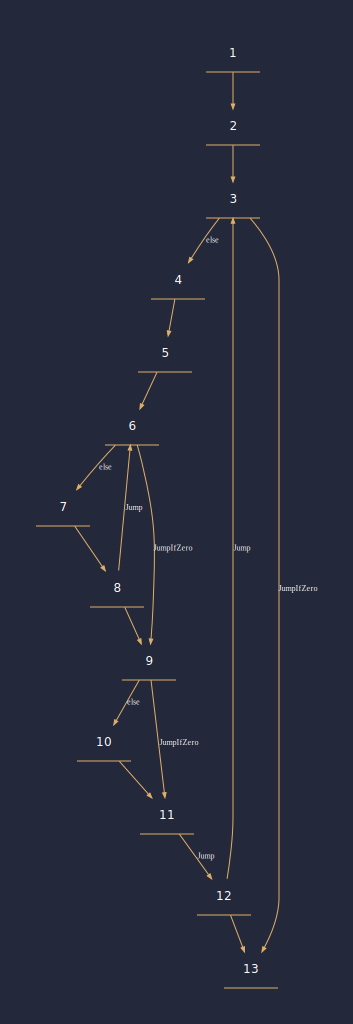

In [152]:
visualize(cfg_collatz,'collatz.cfg',save=False)

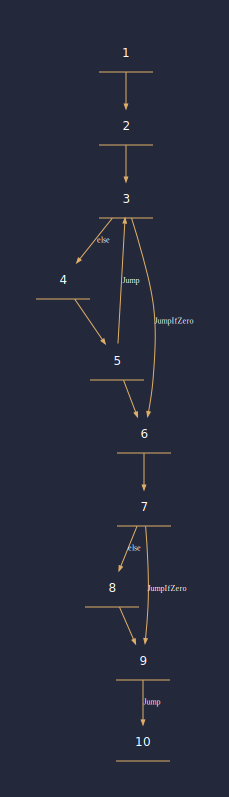

In [141]:
visualize(cfg_arith,'arith.cfg',save=False)

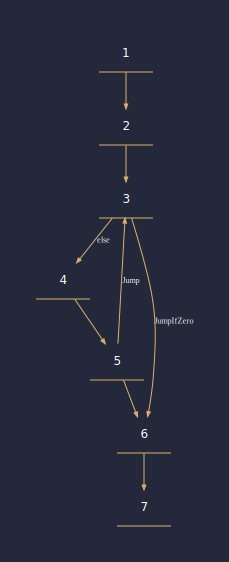

In [142]:
visualize(cfg_factorial,'factorial.cfg',save=False)